In [ ]:
%cd "/content/drive/MyDrive/NAPE COURSE/wige"

/content/drive/MyDrive/NAPE COURSE/wige


In [ ]:
!pip install pandas==1.4.3
!pip install numpy==1.22.4
!pip install lasio
!pip install petrolib
!pip install petroeval

  Using cached lasio-0.31-py2.py3-none-any.whl (47 kB)
  Using cached petrolib-1.2.6-py3-none-any.whl (32 kB)
  Using cached contextily-1.6.0-py3-none-any.whl (17 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
  Using cached rasterio-1.3.9-cp310-cp310-manylinux2014_x86_64.whl (20.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 4.9 MB/s eta 0:00:00
  Attempting uninstall: lasio
    Found existing installation: lasio 0.31
    Uninstalling lasio-0.31:
      Successfully uninstalled lasio-0.31


In [ ]:
from pathlib import Path

import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import petroeval as pet
from petrolib.plots import tripleCombo, Zonation, plotLog

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as sklm

In [ ]:
las = pet.read_lasio("./data/W.las")
test_df1 = las.df()
test_df = test_df1.copy()
test_df1["DEPTH"] = test_df1.index

In [ ]:
columns = list(test_df1.columns)
test_df = test_df[columns[:10]]
test_df["FLUIDTYPES"] = test_df1["FLUIDTYPES"]

In [ ]:
test_df

,CALI,DT,GR,ILD,LLS,MSFL,NPHI,RHOB,SP,DEPT_1,FLUIDTYPES
DEPT,,,,,,,,,,,
4347.5,NaN,NaN,77.943199,NaN,NaN,NaN,NaN,NaN,88.919998,1325.118042,NaN
4348.0,NaN,NaN,77.943199,NaN,NaN,NaN,NaN,NaN,88.925201,1325.270386,NaN
4348.5,NaN,NaN,77.943199,NaN,NaN,NaN,NaN,NaN,88.930397,1325.422852,NaN
4349.0,NaN,NaN,77.943199,NaN,NaN,NaN,NaN,NaN,88.969498,1325.575195,NaN
4349.5,NaN,NaN,77.943199,-0.0569,NaN,NaN,NaN,NaN,89.614197,1325.727539,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14354.0,NaN,81.143097,77.040001,11.0400,NaN,NaN,NaN,NaN,-25.639999,4375.099121,NaN
14354.5,NaN,81.342102,77.460602,11.9417,NaN,NaN,NaN,NaN,-25.268600,4375.251465,NaN
14355.0,NaN,81.034805,77.619904,12.3800,NaN,NaN,NaN,NaN,-24.909599,4375.403809,NaN


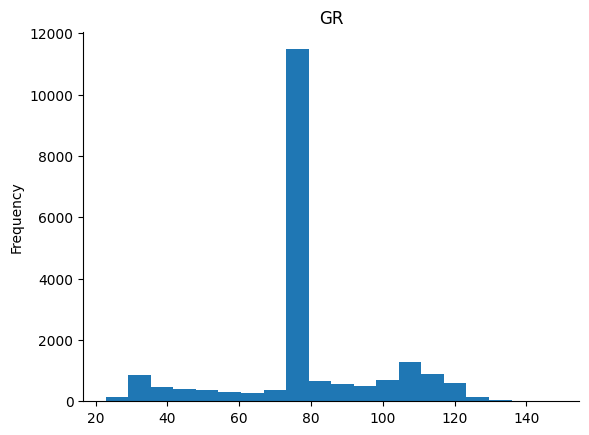

In [ ]:
# @title GR

from matplotlib import pyplot as plt
test_df['GR'].plot(kind='hist', bins=20, title='GR')
plt.gca().spines[['top', 'right',]].set_visible(False)

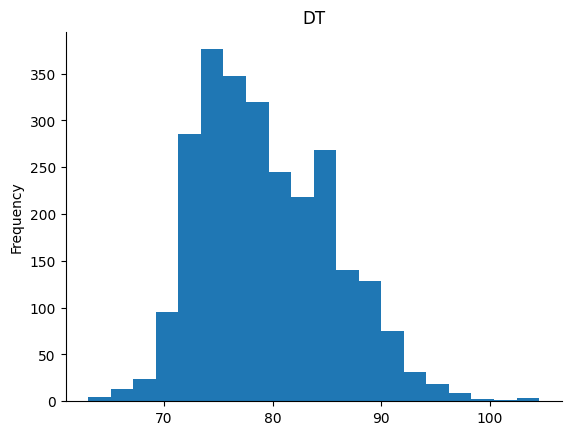

In [ ]:
# @title DT

from matplotlib import pyplot as plt
test_df['DT'].plot(kind='hist', bins=20, title='DT')
plt.gca().spines[['top', 'right',]].set_visible(False)

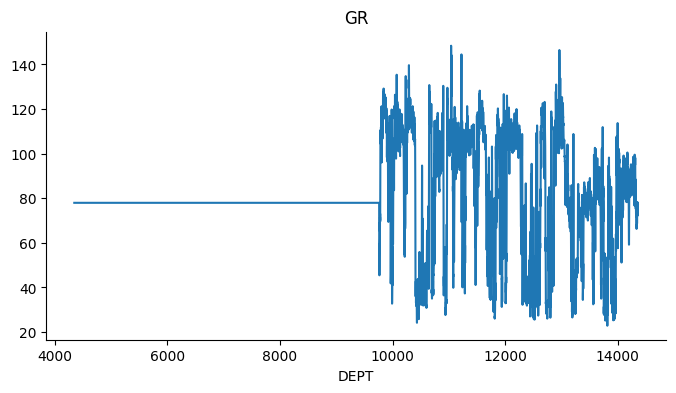

In [ ]:
# @title GR

from matplotlib import pyplot as plt
test_df['GR'].plot(kind='line', figsize=(8, 4), title='GR')
plt.gca().spines[['top', 'right']].set_visible(False)

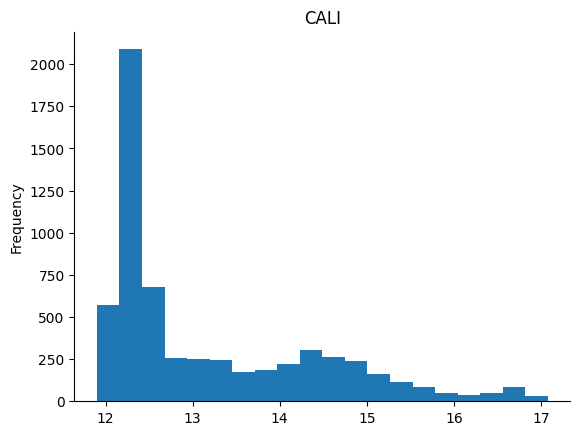

In [ ]:
# @title CALI

from matplotlib import pyplot as plt
test_df['CALI'].plot(kind='hist', bins=20, title='CALI')
plt.gca().spines[['top', 'right',]].set_visible(False)

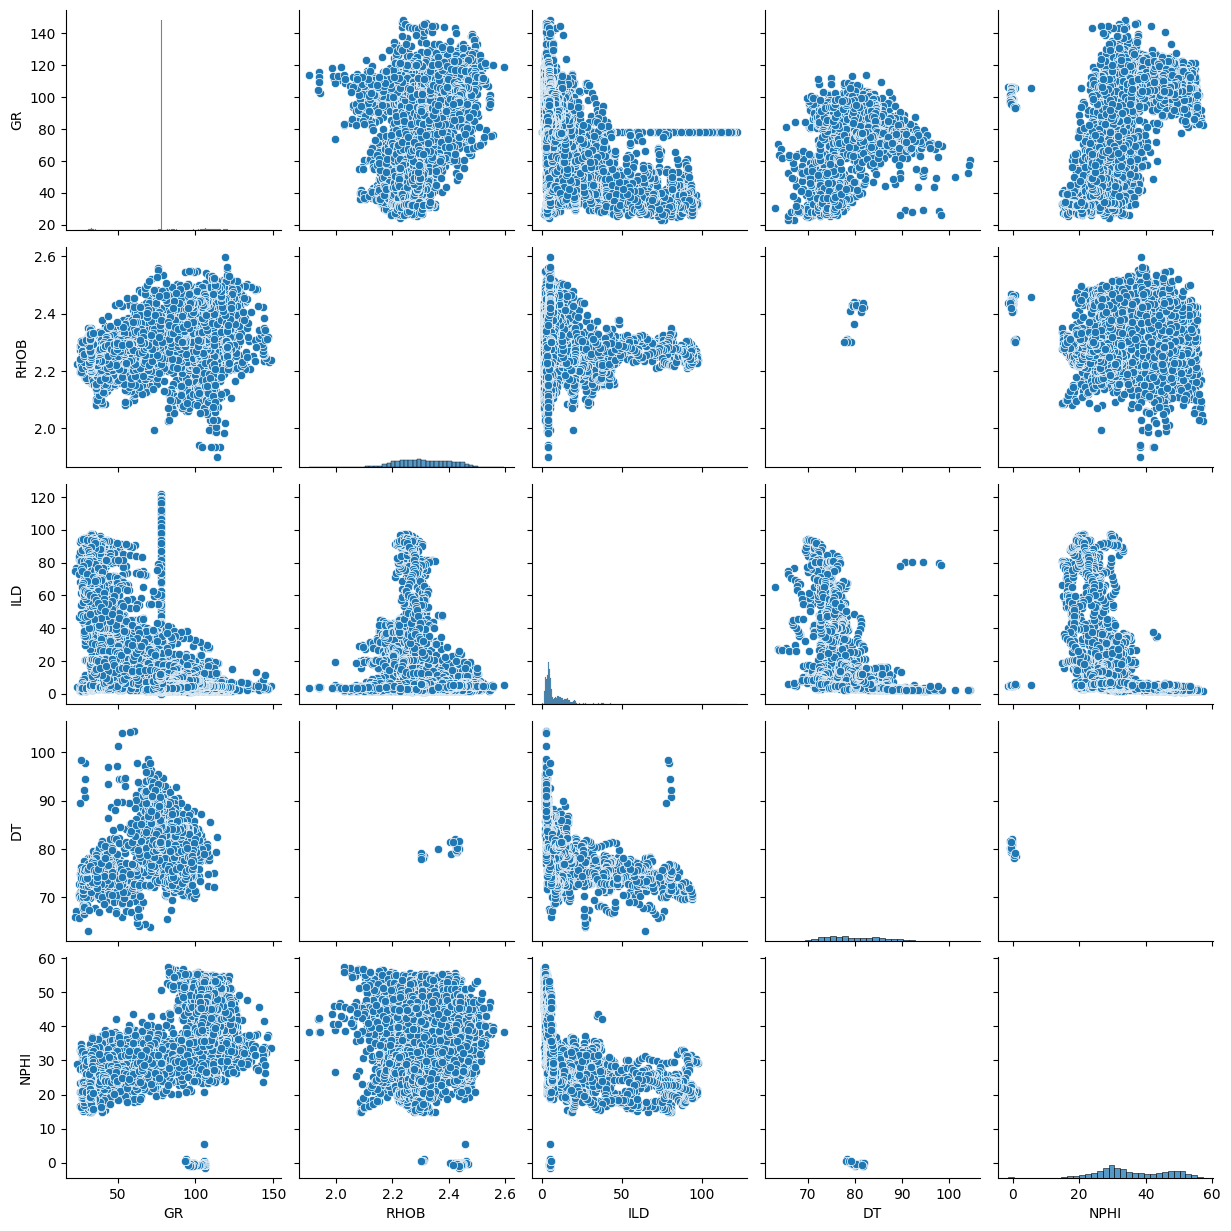

In [ ]:
sns.pairplot(test_df[["GR", "RHOB", "ILD", "DT", "NPHI"]])

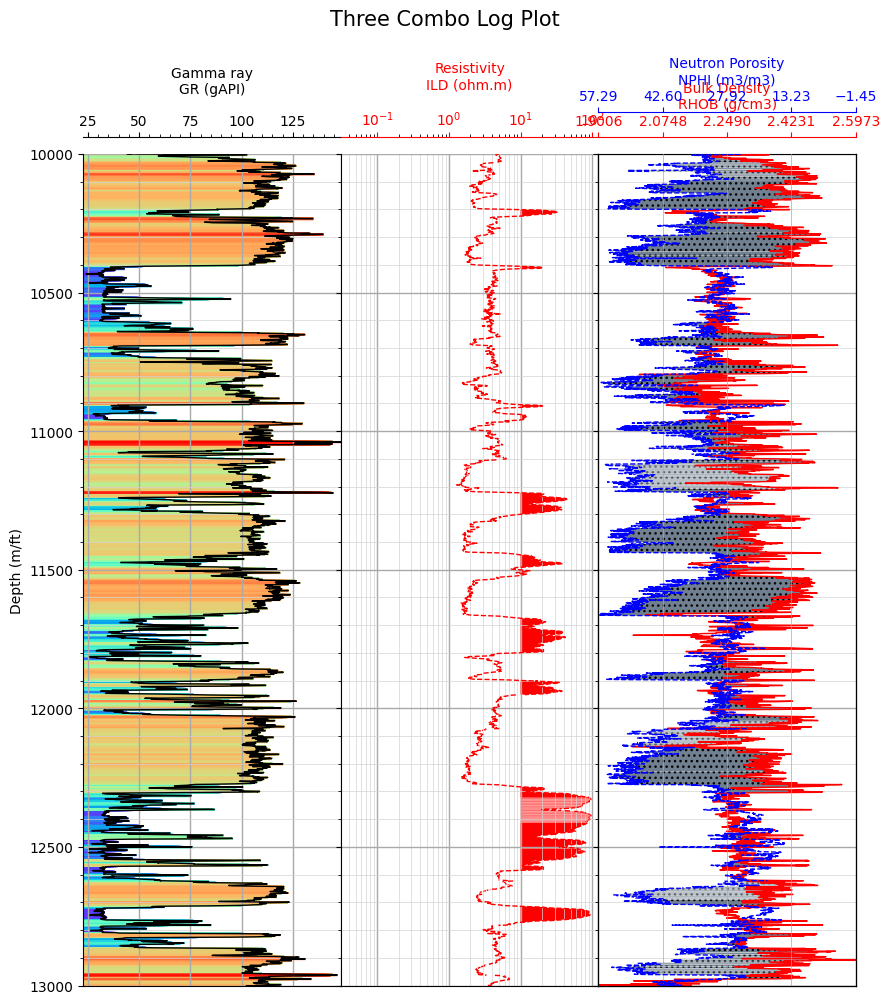

In [ ]:
tripleCombo(test_df1, 'DEPTH', 'GR', 'ILD', 'NPHI', 'RHOB', ztop=10000,
            zbot=13000, res_thres=10, fill='right', palette_op='rainbow', limit='left')

# ETL

In [ ]:
las1 = pet.read_lasio("./data/X.las")
las2 = pet.read_lasio("./data/Y.las")
las3 = pet.read_lasio("./data/Z.las")
train_df1 = las1.df()
train_df2 = las2.df()
train_df3 = las3.df()

# Data Preparation

In [ ]:
train_df1 = train_df1[["GR", "RHOB", "ILD", "SP", "NPHI", "FLUIDTYPES"]]
train_df2 = train_df2[["GR", "RHOB", "ILD", "SP", "NPHI", "FLUIDTYPES"]]
train_df3 = train_df3[["GR", "RHOB", "ILD", "SP", "NPHI", "FLUIDTYPES"]]

train_df = pd.concat((train_df1, train_df2, train_df3))
train_df.isna().sum()/train_df.shape[0]

GR            0.350275
RHOB          0.512299
ILD           0.328887
SP            0.059084
NPHI          0.547817
FLUIDTYPES    0.149588
dtype: float64

In [ ]:
train_df.dropna(subset=['FLUIDTYPES'], inplace=True)
train_df.fillna(-999, inplace=True)
labels = train_df.FLUIDTYPES
features = train_df.drop("FLUIDTYPES", axis=1)

test_labels = test_df.FLUIDTYPES.fillna(3).values

In [ ]:
test_df = test_df.fillna(-999)
test_df = test_df[["GR", "RHOB", "ILD", "SP", "NPHI"]]

# Predictive Analysis

## Model Training

In [ ]:
model = RandomForestClassifier(n_estimators=100, verbose=2)
model = xgb.XGBClassifier(n_estimators=1000, max_depth=6, verbose=100)
model.fit(features, labels, verbose=100)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Fluid Prediction and Model Evaluation

In [ ]:
test_df

,GR,RHOB,ILD,SP,NPHI
DEPT,,,,,
4347.5,77.943199,-999.0,-999.0000,88.919998,-999.0
4348.0,77.943199,-999.0,-999.0000,88.925201,-999.0
4348.5,77.943199,-999.0,-999.0000,88.930397,-999.0
4349.0,77.943199,-999.0,-999.0000,88.969498,-999.0
4349.5,77.943199,-999.0,-0.0569,89.614197,-999.0
...,...,...,...,...,...
14354.0,77.040001,-999.0,11.0400,-25.639999,-999.0
14354.5,77.460602,-999.0,11.9417,-25.268600,-999.0
14355.0,77.619904,-999.0,12.3800,-24.909599,-999.0


In [ ]:
def evaluate_predictions(actual, pred):
    print(f"accuracy is: {(sklm.accuracy_score(actual, pred))}")
    print(f"f1 score is: {sklm.f1_score(actual, pred, average='weighted')}")
    print(f"precision is: {sklm.precision_score(actual, pred, average='weighted')}")
    print(f"recall is: {sklm.recall_score(actual, pred, average='weighted')}")

predictions = model.predict(test_df)
evaluate_predictions(test_labels.ravel(), predictions)

accuracy is: 0.9456988710160855
f1 score is: 0.9435725977023884
precision is: 0.948438377007882
recall is: 0.9456988710160855


In [ ]:
test_df["Predicted_Fluid"] = predictions
test_df["FLUIDTYPES"] = test_labels

In [ ]:
def make_facies_log_plot(logs, x1, x2, x3, x4, x5, Depth=False):

    logs = logs.fillna(0)
    if Depth == False:
        logs['Depth'] = logs.index
        Depth = 'Depth'
        ztop=logs.Depth.min(); zbot=logs.Depth.max()

    else:
        logs['Depth'] = logs[Depth]
        Depth = 'Depth'
        ztop=logs.Depth.min(); zbot=logs.Depth.max()

    logs = logs.sort_values(by='Depth', ascending=True)

    facies_colors = [
        '#196F3D', '#FF0000', '#00FFFF', '#000000'
    ]

    facies_labels = [
        'Gas', 'Oil', 'Water', 'Undifferentiated'
    ]

    facies_colormap = {}
    for ind, label in enumerate(facies_labels):
        facies_colormap[label] = facies_colors[ind]

    no = 4
    #no = len(list(dict(logs[target].value_counts())))
    cmap_facies = colors.ListedColormap(
            facies_colors[0 : no], 'indexed'
            )

    cluster=np.repeat(np.expand_dims(logs['FLUIDTYPES'].values,1), 100, 1)
    cluster1=np.repeat(np.expand_dims(logs['Predicted_Fluid'].values,1), 100, 1)

    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
    ax[0].plot(logs[x1], logs.Depth, '-g')
    ax[1].plot(logs[x2], logs.Depth, '-')
    ax[2].plot(logs[x3], logs.Depth, '-', color='0.5')
    ax[3].plot(logs[x4], logs.Depth, '-', color='r')
    ax[4].plot(logs[x5], logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=4)
    im1=ax[6].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=4)

    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((50*' ').join([
        'Gas', 'Oil', 'Water', 'Undifferentiated'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    cbar1=plt.colorbar(im1, cax=cax)
    cbar1.set_label((50*' ').join([
        'Gas', 'Oil', 'Water', 'Undifferentiated'
    ]))
    cbar1.set_ticks(range(0,1)); cbar1.set_ticklabels('')

    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel(x1)
    ax[0].set_xlim(0, logs[x1].max())
    ax[0].set_ylabel("Depth (ft)")
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(1.8, logs[x2].max())
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(0, logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(0, logs[x4].max())
    ax[4].set_xlabel(x5)
    ax[4].set_xscale('log')
    ax[4].set_xlim(logs[x5].min(), logs[x5].max())
    ax[5].set_xlabel('Actual Fluid')
    ax[6].set_xlabel('Predicted Fluid')

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]), ax[6].set_xticklabels([])
    f.suptitle('Well: W', fontsize=14,y=0.94)

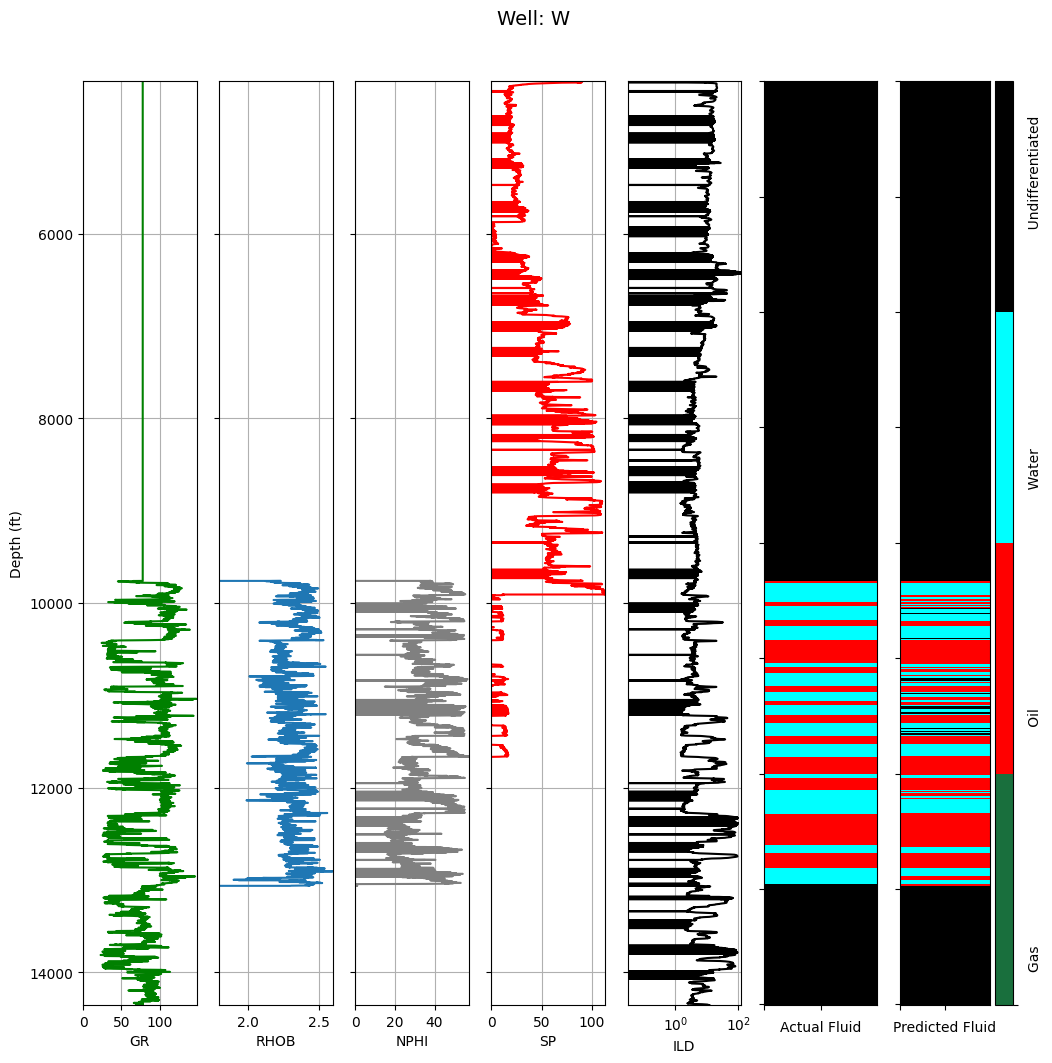

In [ ]:
make_facies_log_plot(test_df, "GR", "RHOB", "NPHI", "SP", "ILD")

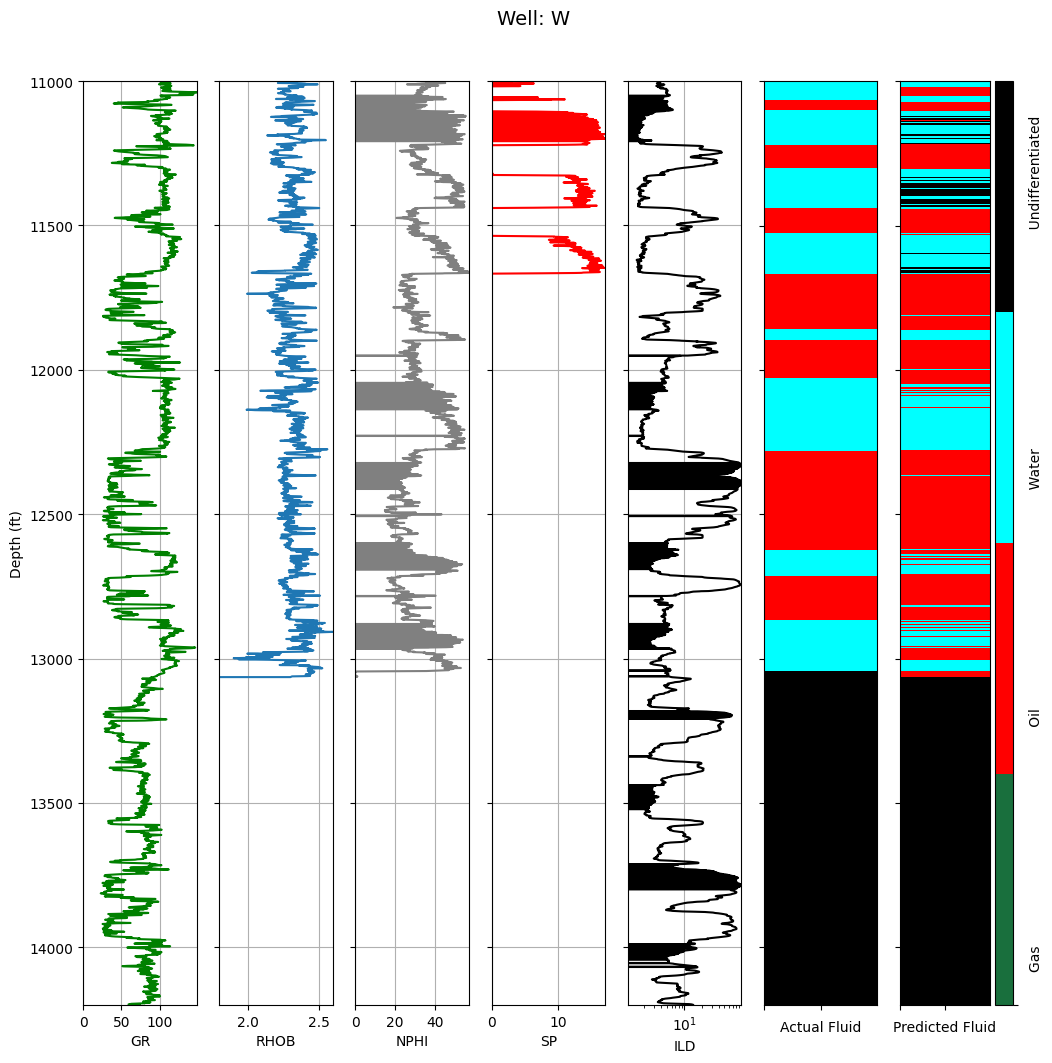

In [ ]:
make_facies_log_plot(test_df.loc[(test_df.index >= 11000) & (test_df.index <= 14200)], "GR", "RHOB", "NPHI", "SP", "ILD", )

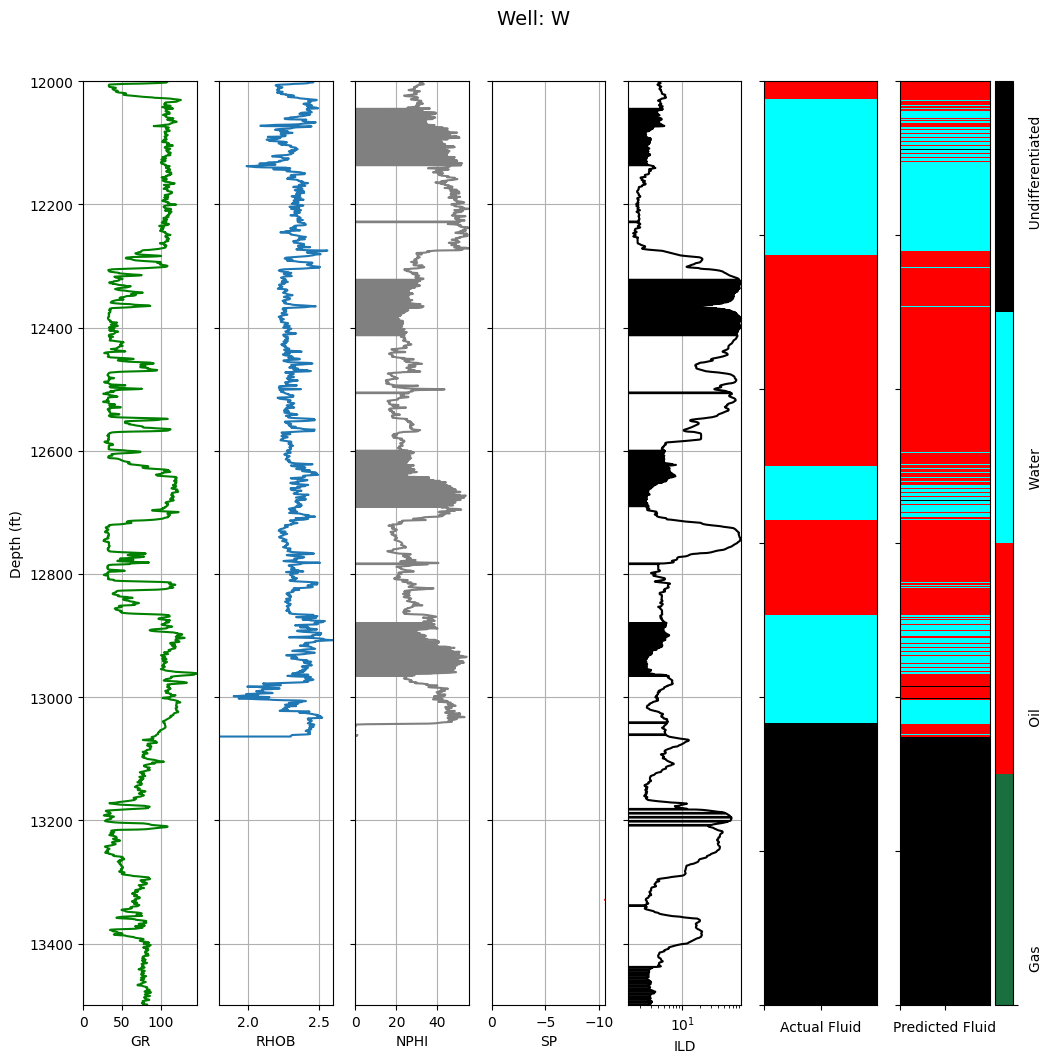

In [ ]:
make_facies_log_plot(test_df.loc[(test_df.index >= 12000) & (test_df.index <= 13500)], "GR", "RHOB", "NPHI", "SP", "ILD", )